In [23]:
## utils
import pandas as pd
import numpy as np

## imports para análise
import statsmodels.api as sm
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

## imports para modelagem
from fbprophet import Prophet
from sklearn.metrics import mean_squared_error,mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
import numpy as np
import math

## Imports para os gráficos
import matplotlib.pyplot as plt
import matplotlib as mat
from pylab import rcParams

plt.style.use('fivethirtyeight')
mat.rcParams['axes.labelsize'] = 10
mat.rcParams['xtick.labelsize'] = 8
mat.rcParams['ytick.labelsize'] = 8
mat.rcParams['grid.alpha'] = 0.4
mat.rcParams['text.color'] = 'k'
rcParams['figure.figsize'] = 16,6

In [24]:
def load_data(list_of_rows):
    """ Lê o arquivo csv de treino e retorna um dataframe contendo somente as linhas especificadas em list_of_rows """
    
    df = (
        pd.read_csv('../data/train_1.csv')
        .iloc[list_of_rows,:]
        .assign(Page = lambda x: x.Page.str.split('.wikipedia.',expand=True))
        .rename(columns={'Page':'data'})
        .set_index('data')
        .transpose()
        
    )
    
    df.columns = [x.casefold() for x in df.columns]
    
    return df

In [25]:
df = load_data([39867,11977,4365])
df.index = pd.to_datetime(df.index,format = '%Y-%m-%d')
df.head()

,captain_america_en,the_empire_strikes_back_en,albert_camus_fr
2015-07-01,6201.0,1357.0,1025.0
2015-07-02,5621.0,1353.0,860.0
2015-07-03,5883.0,1250.0,515.0
2015-07-04,10237.0,1153.0,395.0
2015-07-05,13579.0,1390.0,506.0


In [26]:
df.isna().sum()

captain_america_en            0
the_empire_strikes_back_en    0
albert_camus_fr               0
dtype: int64

In [27]:
def decompose_serie(serie):
    """ Recebe uma série e plota a sua decomposição nos componentes de uma série temporal """

    ## multiplicativa
    mult = sm.tsa.seasonal_decompose(serie, model='multiplicative',extrapolate_trend='freq')
    
    # plotando
    plt.rcParams.update({'figure.figsize': (20,8)})
    mult.plot()#.suptitle("Decompisição Mutiplicativa", fontsize=22)
    plt.show()
    
    return mult.resid

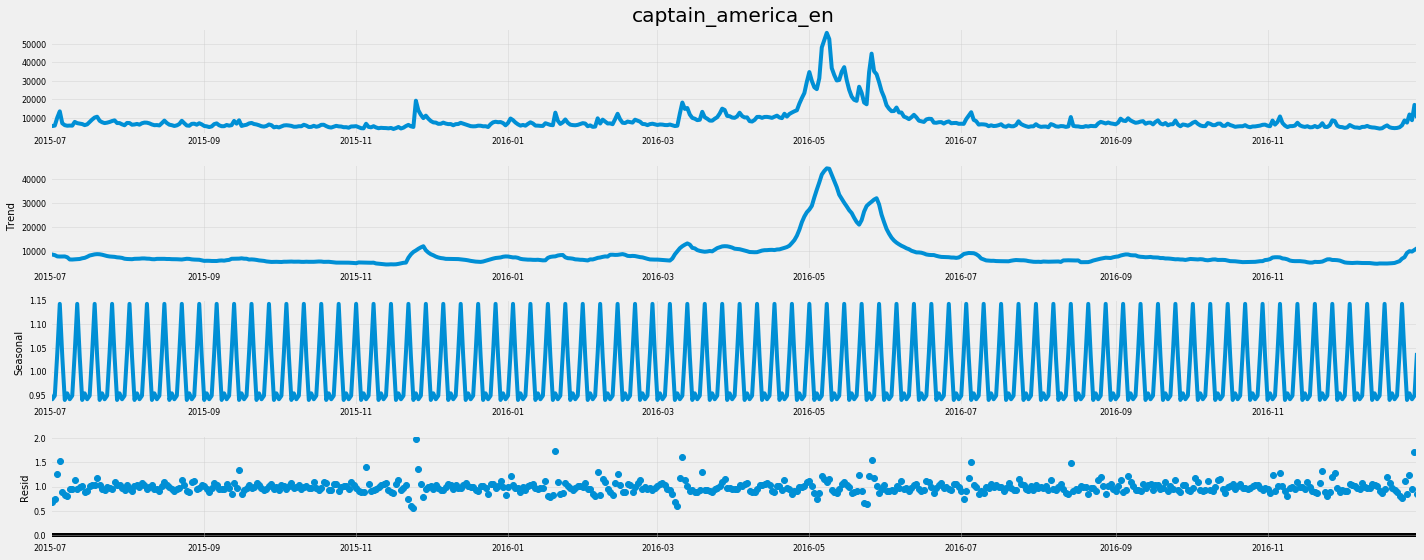

In [28]:
resid_cap = decompose_serie(df.captain_america_en)

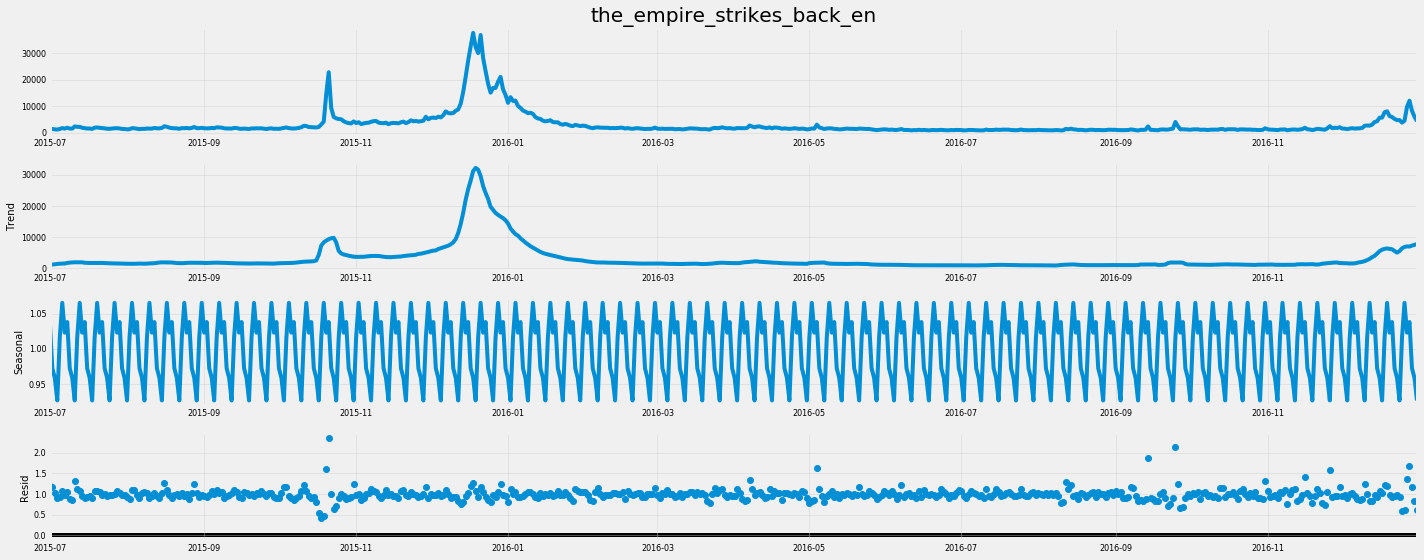

In [29]:
resid_empire = decompose_serie(df.the_empire_strikes_back_en)

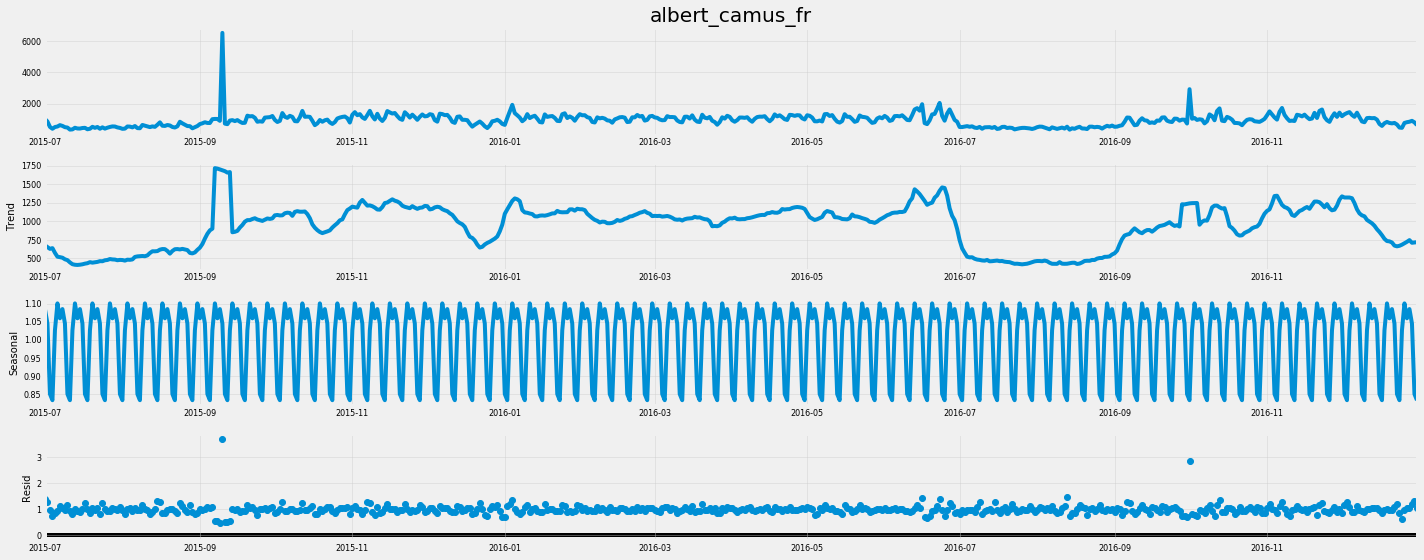

In [30]:
resid_albert = decompose_serie(df.albert_camus_fr)

In [31]:
## decompondo
teste = sm.tsa.seasonal_decompose(df.captain_america_en, model='multiplicative',extrapolate_trend='freq')

## salvando os componentes
resid = teste.resid
season = teste.seasonal
trend = teste.trend

## criando o dataframe
teste_df = pd.DataFrame([resid,season,trend]).transpose().assign(total = lambda x: x.resid * x.seasonal * x.trend).assign(valores_reais = df.captain_america_en)
teste_df

,resid,seasonal,trend,total,valores_reais
2015-07-01,0.736869,0.954274,8818.571429,6201.0,6201.0
2015-07-02,0.695596,0.941801,8580.204082,5621.0,5621.0
2015-07-03,0.742934,0.949264,8341.836735,5883.0,5883.0
2015-07-04,1.259286,1.039370,7821.285714,10237.0,10237.0
2015-07-05,1.530355,1.142810,7764.285714,13579.0,13579.0
...,...,...,...,...,...
2016-12-27,0.858702,0.940249,9270.571429,7485.0,7485.0
2016-12-28,1.247537,0.954274,9982.428571,11884.0,11884.0
2016-12-29,0.950180,0.941801,9829.250000,8796.0,8796.0
2016-12-30,1.711409,0.949264,10507.948980,17071.0,17071.0


In [32]:
teste_df[(teste_df.resid > 0.999) & (teste_df.resid < 1.0)]

,resid,seasonal,trend,total,valores_reais
2016-08-02,0.999745,0.940249,5522.285714,5191.0,5191.0


In [33]:
5522.285714 * 0.940249

5192.3236203027855

In [34]:
teste_df.iloc[np.argmax(teste_df.resid),:]

resid                1.972543
seasonal             0.954274
trend            10272.285714
total            19336.000000
valores_reais    19336.000000
Name: 2015-11-25 00:00:00, dtype: float64

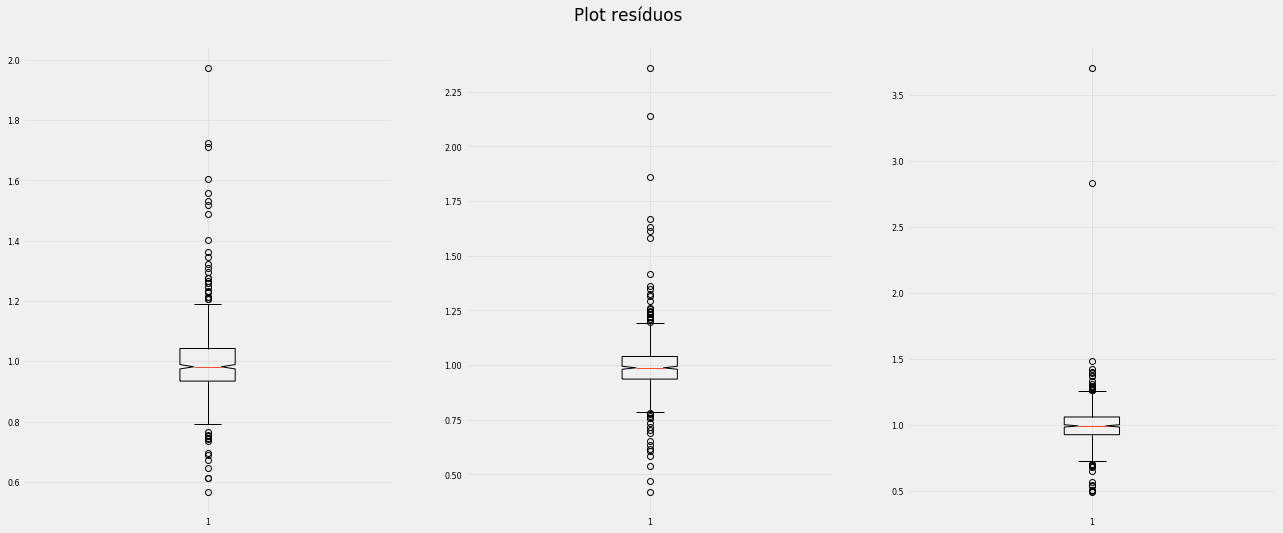

In [35]:
f, axes = plt.subplots(1,3)
plt.suptitle('Plot resíduos',y=0.95)

axes[0].boxplot(resid_cap,notch=True)
axes[1].boxplot(resid_empire,notch=True)
axes[2].boxplot(resid_albert,notch=True)

plt.show()

In [36]:
def test_stationary(serie,janela=30):
    
    """ Recebe uma série plota suas estatíticas móveis, executa o teste adfuller e printa uma conclusão """
    
    ## plotando as médias e variâncias dentro de uma determinada janela
    rolmean = serie.rolling(window = janela).mean()
    rolstd = serie.rolling(window = janela).std()
    
    # Plot das estatísticas móveis
    orig = plt.plot(serie, color = 'blue', label = 'Original')
    mean = plt.plot(rolmean, color = 'red', label = 'Média móvel')
    std = plt.plot(rolstd, color = 'black', label = 'Desvio padrão')
    plt.legend(loc = 'best')
    plt.title("Estatísticas Móveis - Média e Devio Padrão",size=12)
    plt.show()
    
    # Teste Dickey-Fuller
    print("\nResultado do Teste Dickey-Fuller:\n")
    dfteste = adfuller(serie, autolag = 'AIC')
    
    # Formatando a saída
    dfsaida = pd.Series(dfteste[0:4], index = ['Estatítisca do Teste',
                                               'Valor-p',
                                               'Numero de lags consideradas',
                                               'Número de observações usada'])
    
    # Loop por cada item de saída do teste
    for key, value in dfteste[4].items():
        dfsaida["valor Crítico (%s)"%key] = value
        
    # print
    print(dfsaida)
    
    # Testa o valor-p
    print ('\nConclusão:')
    if dfsaida[1] > 0.05:
        print('\nO valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente não é estacionária.')
    else:
        print('\nO valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.')
        print('Essa série provavelmente é estacionária.')  

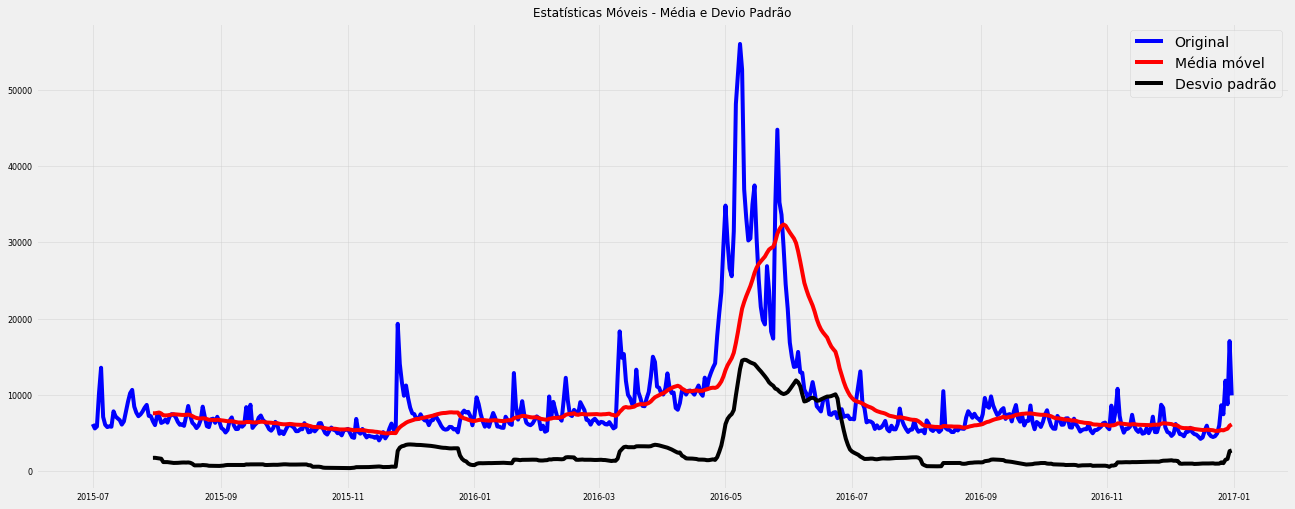


Resultado do Teste Dickey-Fuller:

Estatítisca do Teste            -2.451917
Valor-p                          0.127616
Numero de lags consideradas     17.000000
Número de observações usada    532.000000
valor Crítico (1%)              -3.442702
valor Crítico (5%)              -2.866988
valor Crítico (10%)             -2.569672
dtype: float64

Conclusão:

O valor-p é maior que 0.05 e, portanto, não temos evidências para rejeitar a hipótese nula.
Essa série provavelmente não é estacionária.


In [37]:
test_stationary(df.captain_america_en)

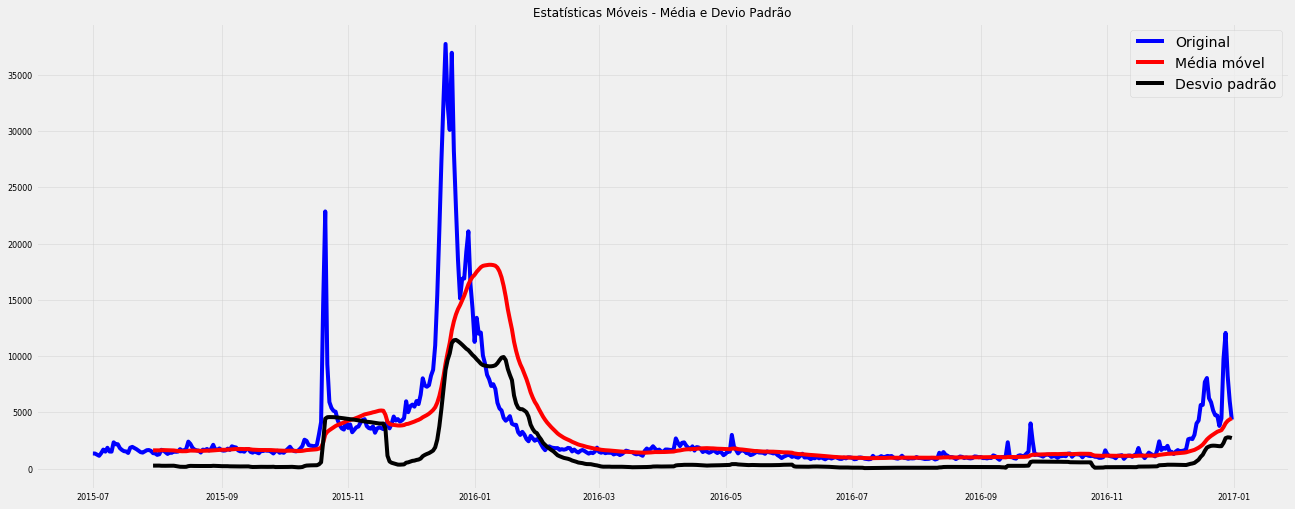


Resultado do Teste Dickey-Fuller:

Estatítisca do Teste            -3.442370
Valor-p                          0.009597
Numero de lags consideradas      6.000000
Número de observações usada    543.000000
valor Crítico (1%)              -3.442450
valor Crítico (5%)              -2.866877
valor Crítico (10%)             -2.569613
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [38]:
test_stationary(df.the_empire_strikes_back_en)

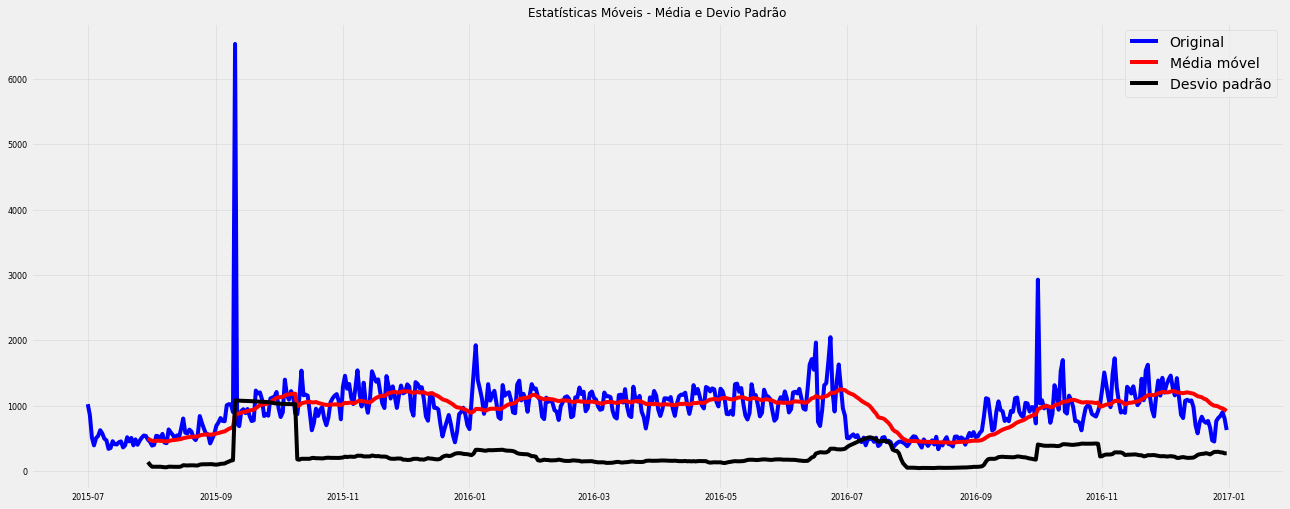


Resultado do Teste Dickey-Fuller:

Estatítisca do Teste            -3.728251
Valor-p                          0.003733
Numero de lags consideradas      6.000000
Número de observações usada    543.000000
valor Crítico (1%)              -3.442450
valor Crítico (5%)              -2.866877
valor Crítico (10%)             -2.569613
dtype: float64

Conclusão:

O valor-p é menor que 0.05 e, portanto, temos evidências para rejeitar a hipótese nula.
Essa série provavelmente é estacionária.


In [39]:
test_stationary(df.albert_camus_fr)

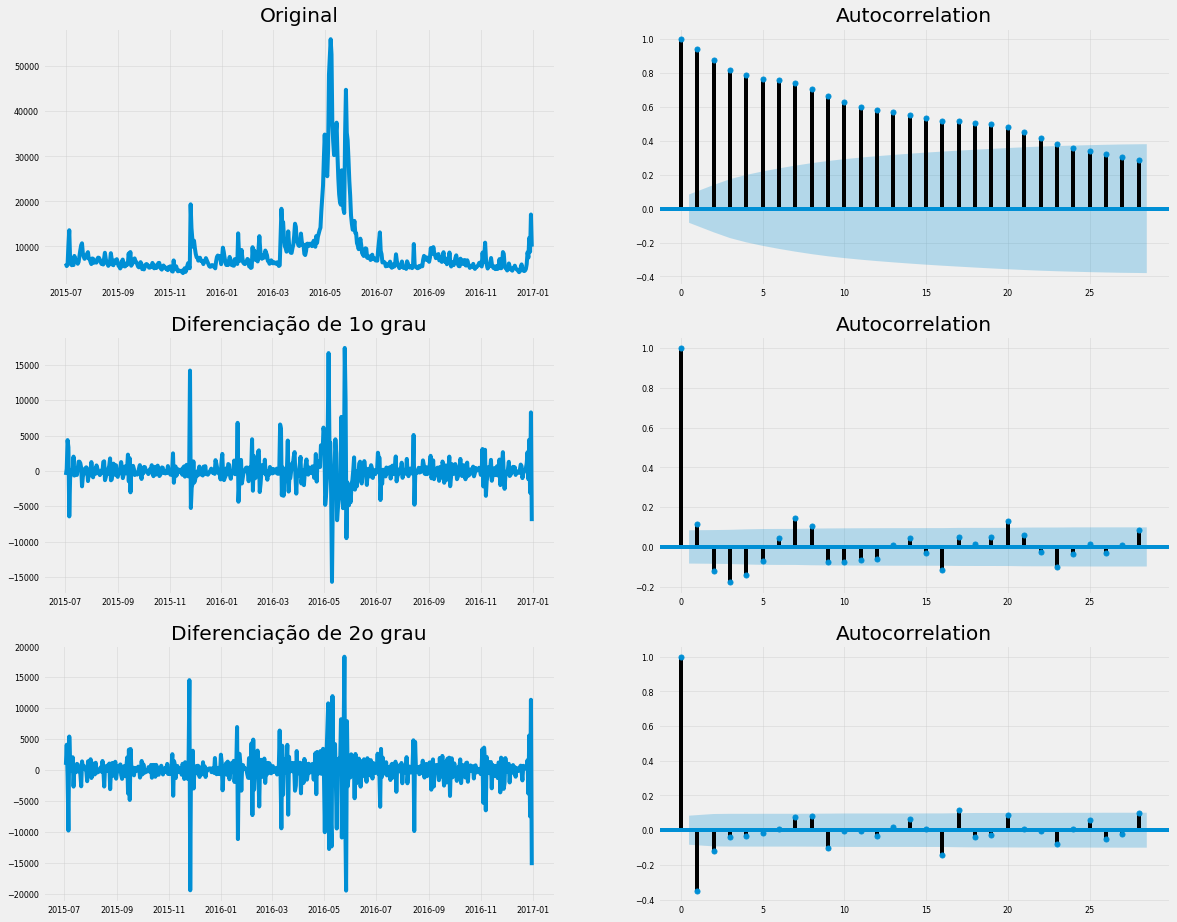

In [40]:
data = df.captain_america_en

f, axes = plt.subplots(3, 2,figsize=(18,15))

axes[0,0].plot(data)
plot_acf(data,ax=axes[0,1]);
axes[0,0].set_title('Original')

axes[1,0].plot(data.diff())
plot_acf(data.diff().dropna(),ax=axes[1,1]);
axes[1,0].set_title('Diferenciação de 1o grau')

axes[2,0].plot(data.diff().diff())
plot_acf(data.diff().diff().dropna(),ax=axes[2,1]);
axes[2,0].set_title('Diferenciação de 2o grau')

f.savefig('../images/diff.png')

In [72]:
def make_pacf_plot(serie):
            
    fig, axes = plt.subplots(1, 2)

    axes[0].plot(serie); 
    axes[0].set_title('Série recebida')

    axes[1].set(ylim=(0,5))
    plot_pacf(serie, ax=axes[1]);

    plt.show()

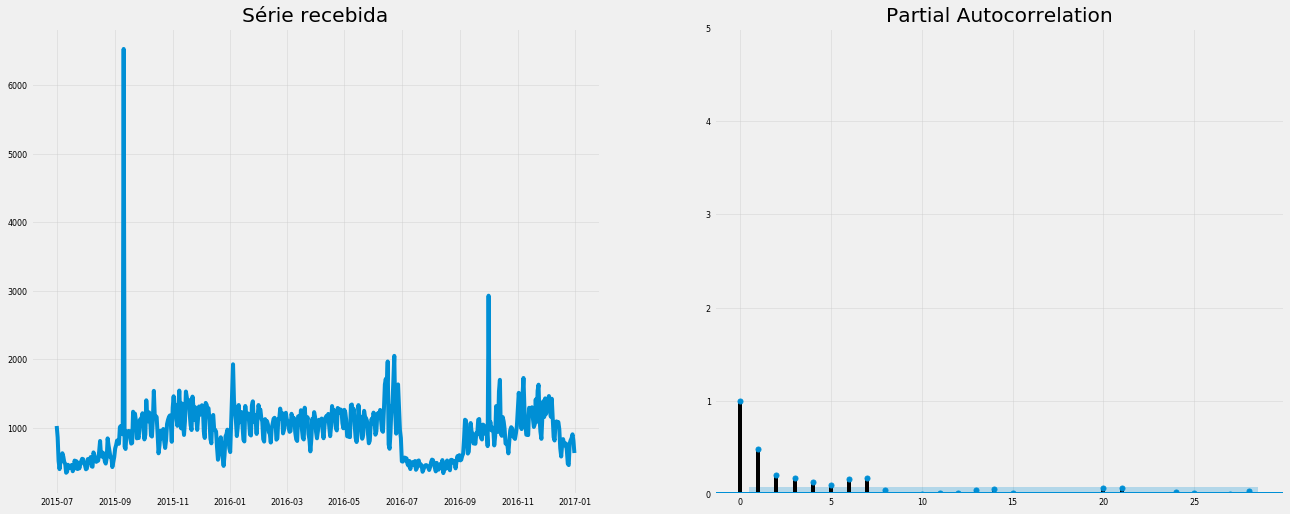

In [77]:
make_pacf_plot(df.albert_camus_fr)

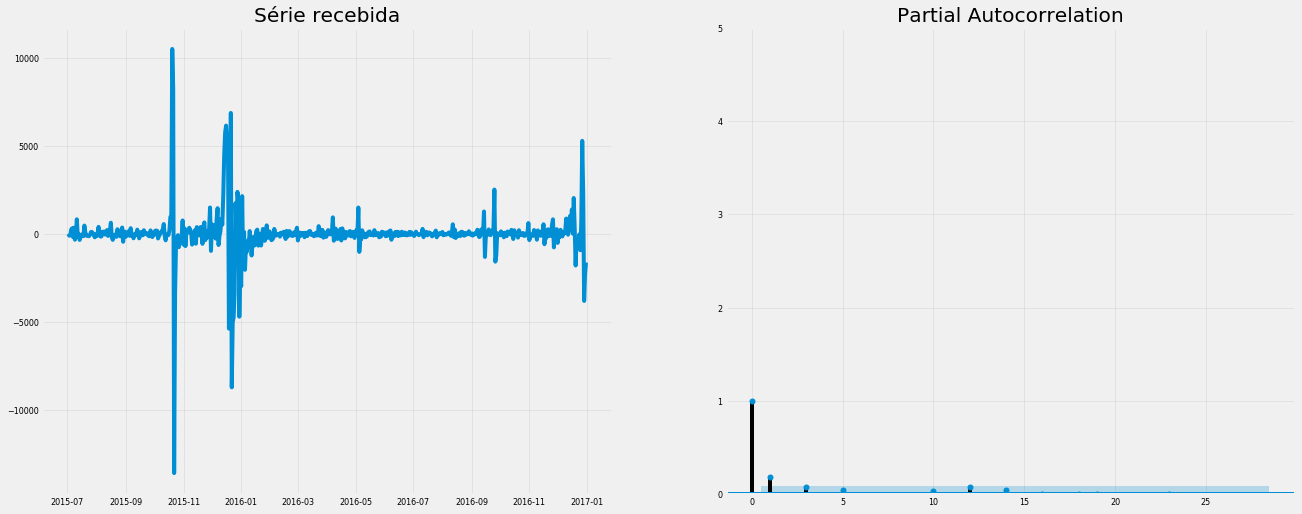

In [78]:
make_pacf_plot(df.the_empire_strikes_back_en.diff().dropna())

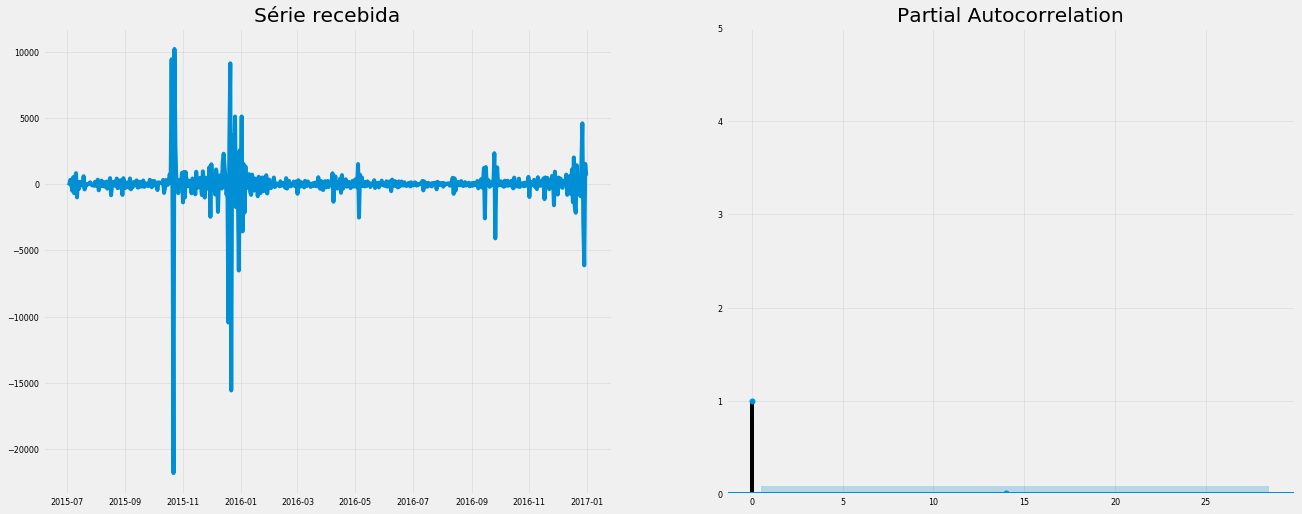

In [79]:
make_pacf_plot(df.the_empire_strikes_back_en.diff().diff().dropna())

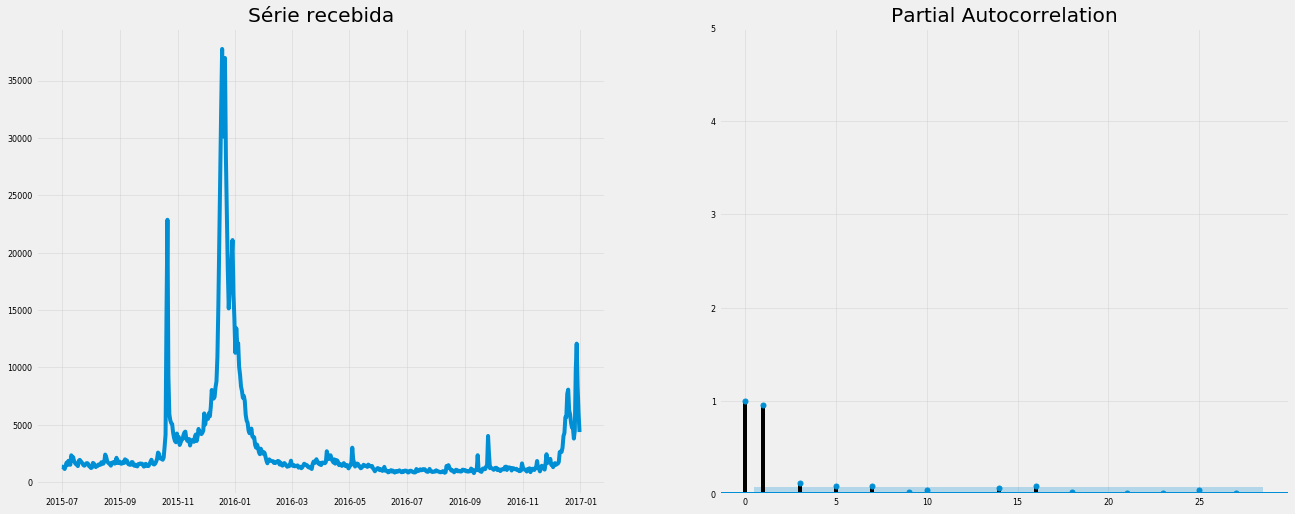

In [80]:
make_pacf_plot(df.the_empire_strikes_back_en)

In [126]:
   
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    mae = np.mean(np.abs(forecast - actual))    # MAE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    return({'mape':mape,'mae': mae,'rmse':rmse})


def arima_modelling(serie,order,alpha=0.05):
    
    train = serie[:-100]
    test = serie[-100:]
    
    model = ARIMA(train, order=order)
    fitted = model.fit(disp=-1)
       
    # Forecast
    fc, se, conf = fitted.forecast(100, alpha=alpha) 

    # Make as pandas series
    fc_series = pd.Series(fc, index=test.index)
    lower_series = pd.Series(conf[:, 0], index=test.index)
    upper_series = pd.Series(conf[:, 1], index=test.index)

    # Plot
    plt.plot(train, label='treino')
    plt.plot(test, label='test')
    plt.plot(fc_series, label='forecast')
    plt.fill_between(lower_series.index, lower_series, upper_series, color='k', alpha=.15)
    plt.title('Forecast vs Real')
    plt.legend(loc='upper left', fontsize=8)
    plt.show()
    
    print(forecast_accuracy(fc,test))


/home/nasserboan/miniconda3/envs/wine-quality/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/home/nasserboan/miniconda3/envs/wine-quality/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


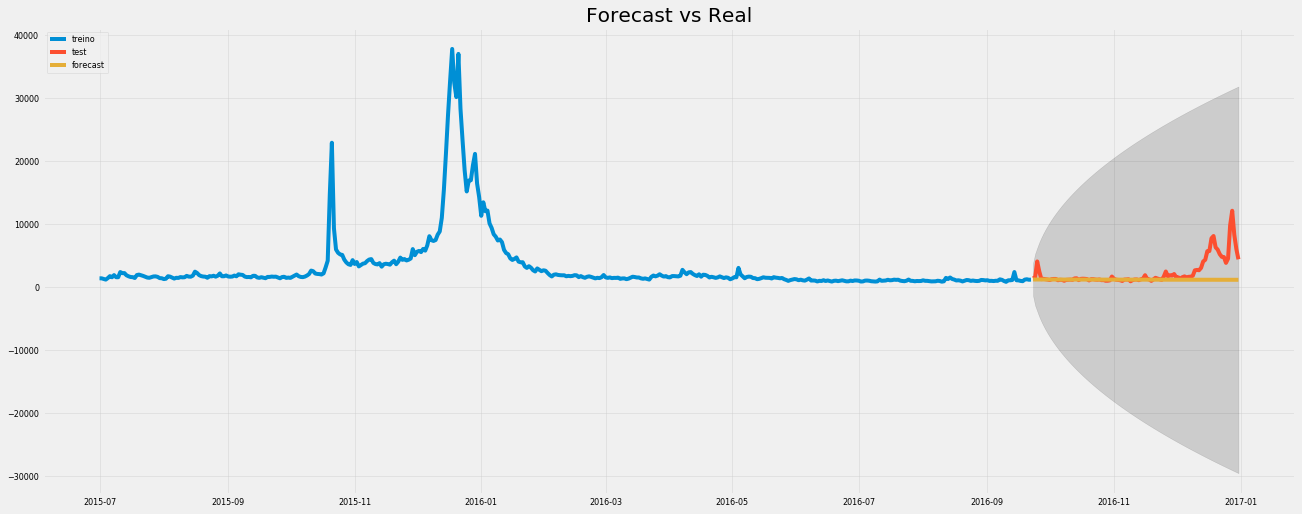

{'mape': 0.2841738144047527, 'mae': 1167.9487504109397, 'rmse': 2386.380965535393}


In [131]:
arima_modelling(df.the_empire_strikes_back_en,order=(3,0,0))

/home/nasserboan/miniconda3/envs/wine-quality/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


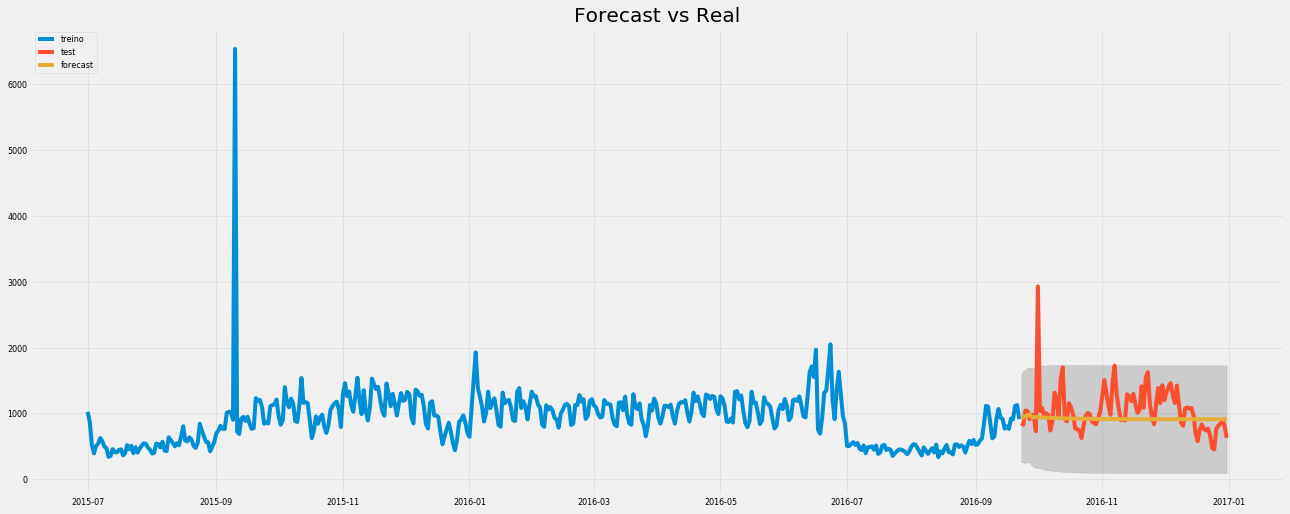

{'mape': 0.20974427241920884, 'mae': 235.3817867301832, 'rmse': 347.8344003243438}


In [140]:
arima_modelling(df.albert_camus_fr,order=(6,0,0))

## Modeling - Prophet

In [ ]:
def prophet_val(page):
    
    ## pegando os dados
    if page == 'captain':
        data = pd.DataFrame(df.captain_america_en).reset_index().rename(columns = {'index':'ds','captain_america_en':'y'})
        plt.title('Capitão América')
    elif page == 'empire':
        data = pd.DataFrame(df.the_empire_strikes_back_en).reset_index().rename(columns = {'index':'ds','the_empire_strikes_back_en':'y'})
        plt.title('O Império Contra Ataca')
    elif page == 'albert':
        data = pd.DataFrame(df.albert_camus_fr).reset_index().rename(columns = {'index':'ds','albert_camus_fr':'y'})
        plt.title('Albert Camus')
        
    ## dividindo em treino e teste
    data_train = data[:-100]
    data_test = data[-100:]

    ## treinando o modelo
    m = Prophet(daily_seasonality=True,yearly_seasonality=True,seasonality_mode='multiplicative')
    m.fit(data_train)

    ## prevendo em teste
    test_pred = m.predict(pd.DataFrame(data_test.ds))['yhat'].values

    ## prevendo em treino
    train_pred = m.predict(pd.DataFrame(data_train.ds))['yhat'].values
             
    ## plotando
    plt.plot(data.y,label='Valor original')
    plt.plot(train_pred,label = 'Valor de treino predito')

    test_pred_plot = [np.nan for _ in range(train_pred.shape[0])]
    for value in test_pred:
        test_pred_plot.append(value)

    plt.plot(test_pred_plot,label = 'Valor de teste predito')
    plt.legend()
    plt.show()

    ## avaliando

    print('## Avaliando o modelo ## \n')
    print(f'Root mean squared error      : {math.sqrt(mean_squared_error(data_test.y,test_pred))}')
    print(f'Mean absolute error          : {mean_absolute_error(data_test.y,test_pred)}')
    
def prophet_future(page,periods=30):
    
    ## pegando os dados
    if page == 'captain':
        data = pd.DataFrame(df.captain_america_en).reset_index().rename(columns = {'index':'ds','captain_america_en':'y'})
        plt.title('Capitão América')
    elif page == 'empire':
        data = pd.DataFrame(df.the_empire_strikes_back_en).reset_index().rename(columns = {'index':'ds','the_empire_strikes_back_en':'y'})
        plt.title('O Império Contra Ataca')
    elif page == 'albert':
        data = pd.DataFrame(df.albert_camus_fr).reset_index().rename(columns = {'index':'ds','albert_camus_fr':'y'})
        plt.title('Albert Camus')

    ## treinando o modelo
    m = Prophet(daily_seasonality=True,yearly_seasonality=True,seasonality_mode='multiplicative')
    m.fit(data)

    ## prevendo em treino
    train_pred = m.predict(pd.DataFrame(data.ds))['yhat'].values

    ## prevendo o futuro em periods
    future = m.make_future_dataframe(periods=periods)
    forecast = m.predict(future.tail(periods)).yhat
    future_plot = [np.nan for _ in range(data.shape[0])]
    for value in forecast:
        future_plot.append(value)


    ## plotando
    plt.plot(data.y,label='Valor original')
    plt.plot(train_pred,label = 'Valor de treino predito')
    plt.plot(future_plot,label = f'Futuro para {periods} dias')
    plt.legend()
    plt.show()

In [ ]:
prophet_val('captain')

In [ ]:
prophet_future('captain')

In [ ]:
prophet_val('empire')

In [ ]:
prophet_future('empire')

In [ ]:
prophet_val('albert')

In [ ]:
prophet_future('albert')